Get PMT positions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import csv
import pandas as pd

# Load the CSV file with pmt x, y z coordinates
data = np.genfromtxt('pmt_positions.csv', delimiter=',', skip_header=1)

# rescale to vectors of length 1

vector_lengths = np.linalg.norm(data, axis=1)
rescaled_data = data / vector_lengths[:, np.newaxis]
vector_lengths_rescaled = np.linalg.norm(rescaled_data, axis = 1)

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta = np.arccos(z / r)
    return r, phi, theta

def convert_points_to_spherical(points):
    points_set_polars = []
    for point in points:
        x = point[0]
        y = point[1]
        z = point[2]
        r, phi, theta = cartesian_to_spherical(x, y, z)
        points_set_polars.append((r, phi, theta))
    return points_set_polars

# transform to polars to plot

points_polars = convert_points_to_spherical(rescaled_data)

# separate coordinates to plot more easily


In [4]:
points_phi = np.zeros(len(points_polars))
points_theta = np.zeros(len(points_polars))

for i in range(len(points_polars)):
    points_phi[i] = points_polars[i][1]
    points_theta[i] = points_polars[i][2]

Get grid (nodes) phi and theta coordinates

In [5]:
nodes = np.genfromtxt('Minimal_Nodes_Grid.csv', delimiter=',', skip_header=1)

In [6]:
print(nodes.shape)


(85, 2)


In [7]:
# Create an array filled with 1s for the first column
column_of_ones = np.ones((nodes.shape[0], 1))

# Stack the column of ones with the last two columns of the original array
new_nodes = np.hstack((column_of_ones, nodes[:, 0].reshape(-1, 1), nodes[:, 1].reshape(-1, 1)))

# Display new_nodes
#print(new_nodes)

In [8]:
def spherical_to_cartesian(r, phi, theta):
    x = r * np.cos(phi) * np.sin(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(theta)
    return x, y, z

In [9]:
def convert_points_to_cartesian(points):
    points_set_cartesians = []
    for point in points:
        r = point[0]
        phi = point[1]
        theta = point[2]
        x, y, z = spherical_to_cartesian(r, phi, theta)
        points_set_cartesians.append((x, y, z))
    return points_set_cartesians

In [10]:
#function that computes the angle between two vectors

def angle_between_vectors(v1, v2):
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
    return angle_rad

In [11]:
points_set_2 = convert_points_to_cartesian(new_nodes)

In [12]:
# find and plot points in cap defined by one of the points first


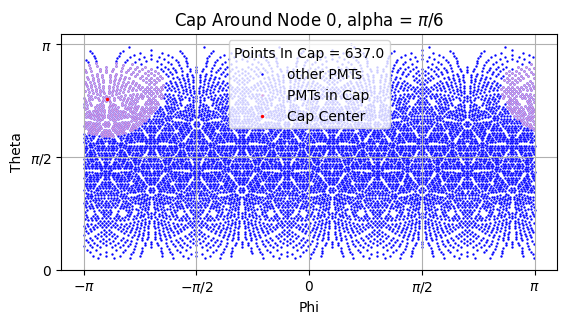

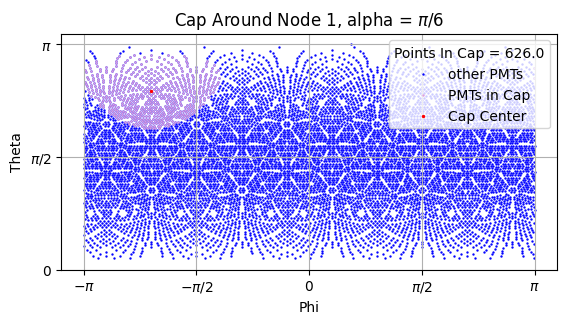

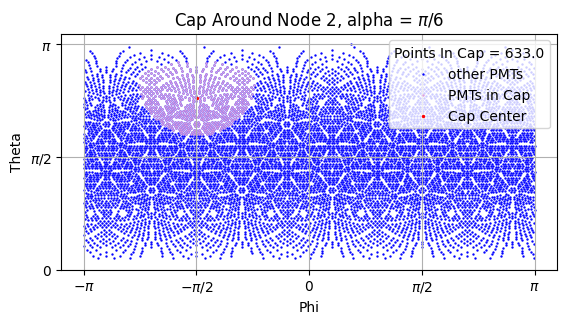

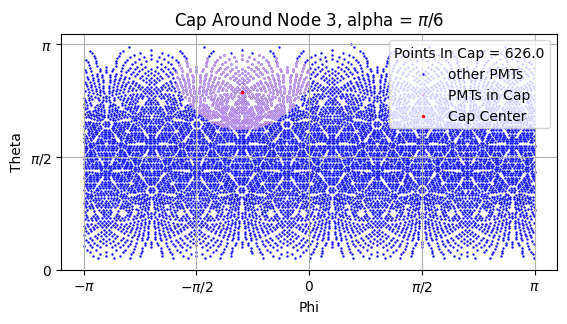

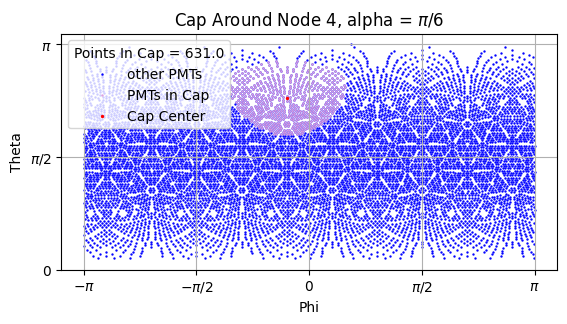

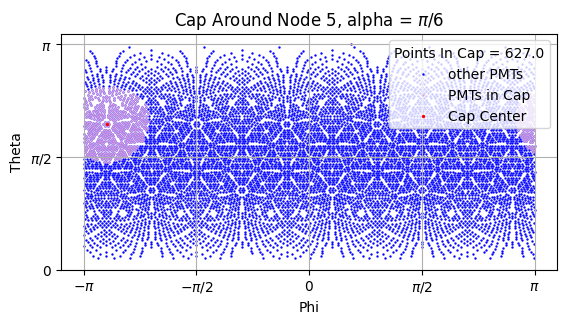

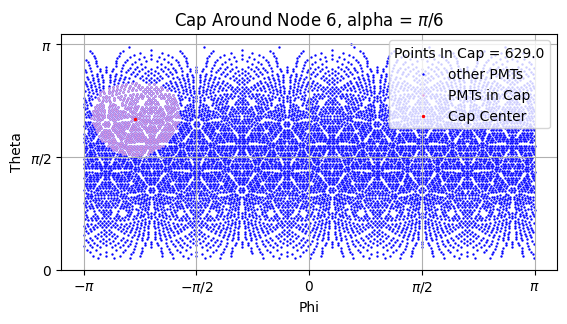

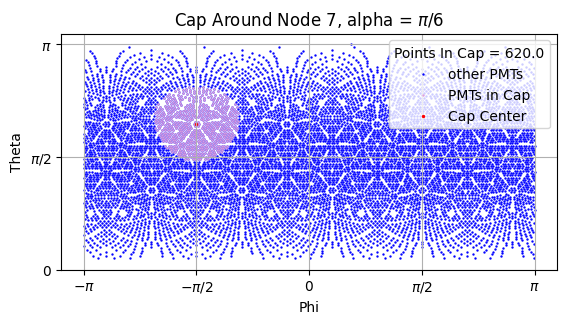

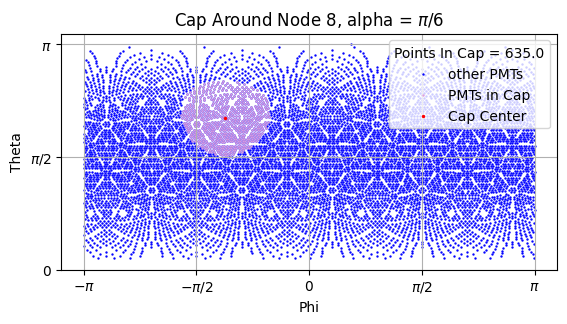

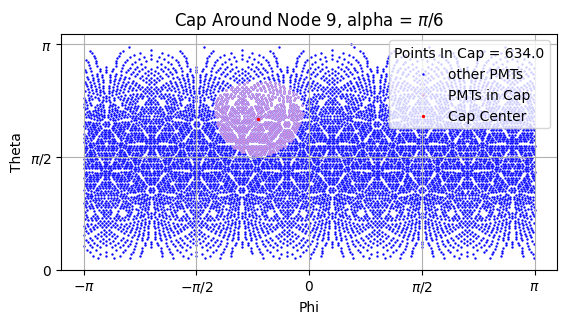

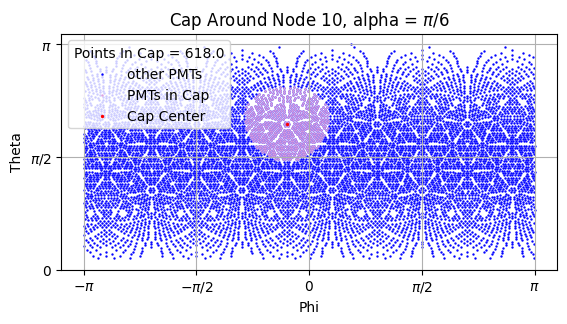

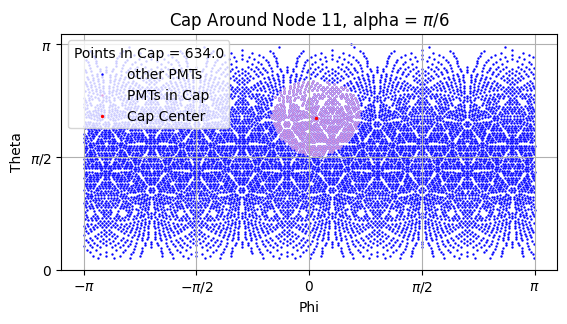

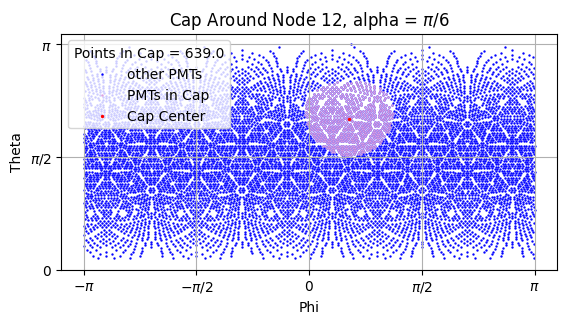

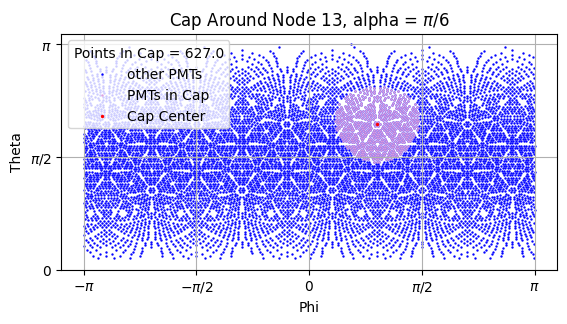

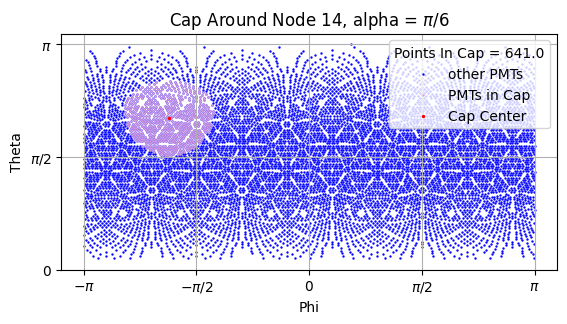

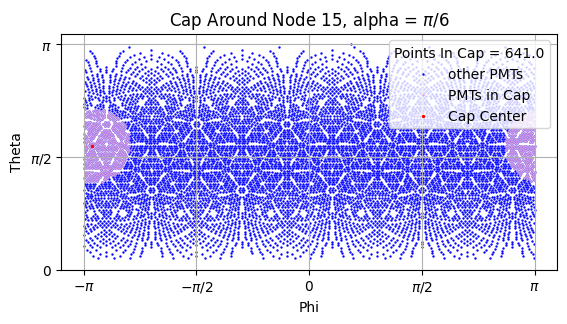

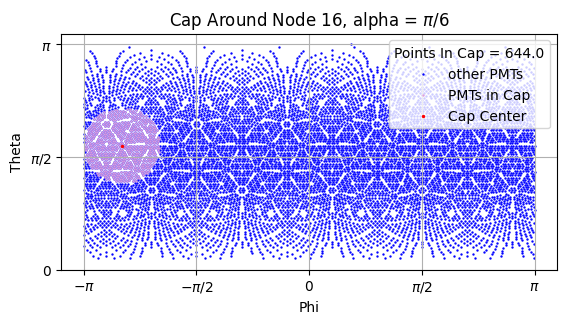

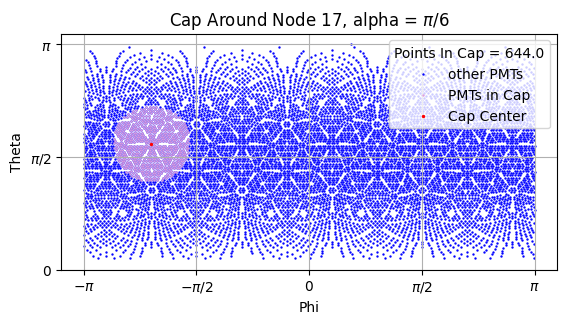

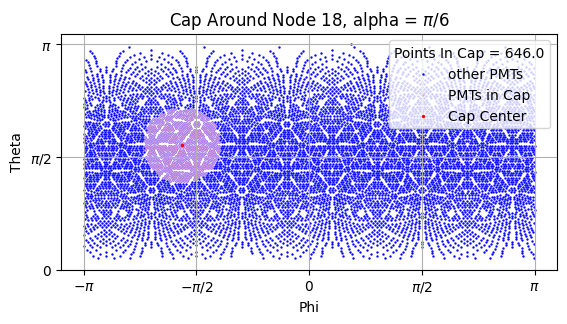

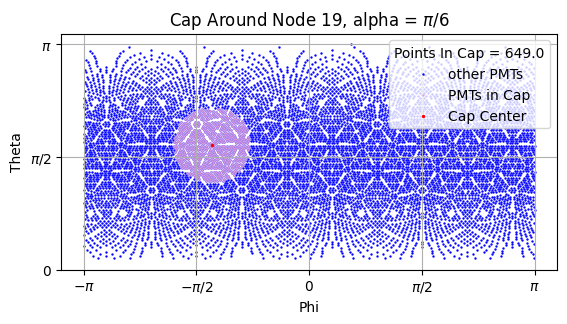

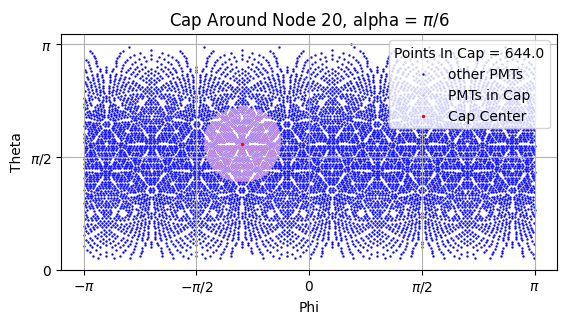

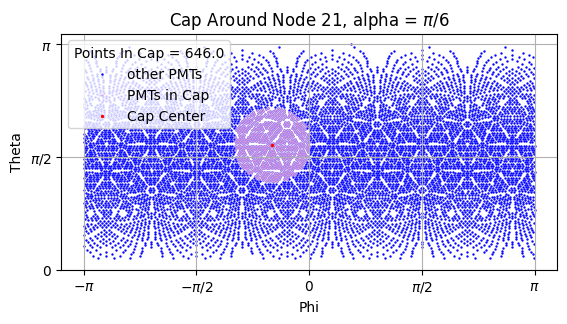

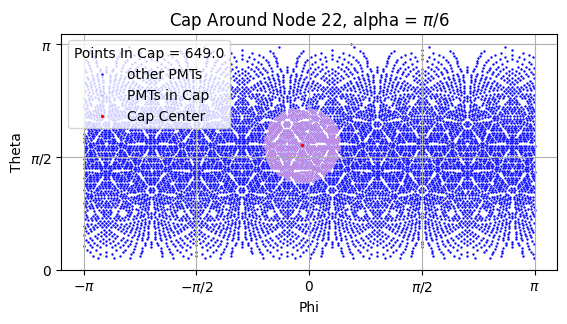

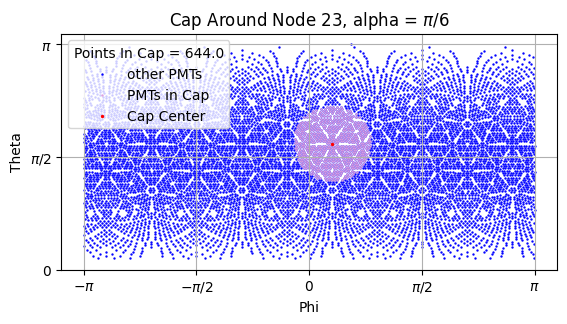

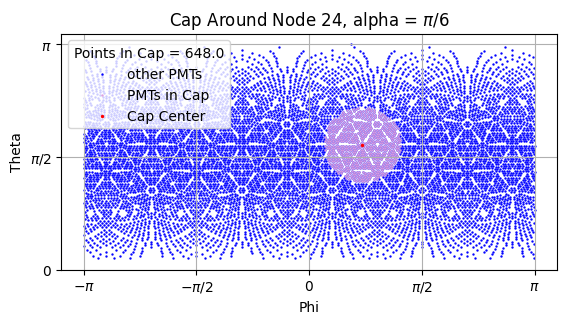

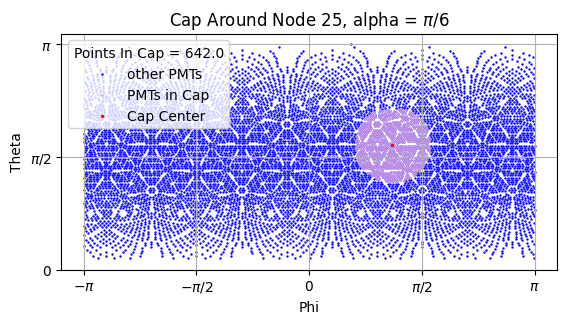

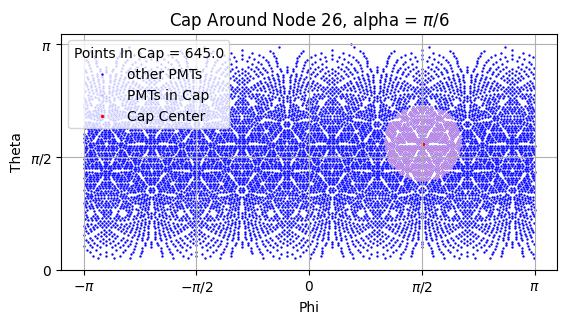

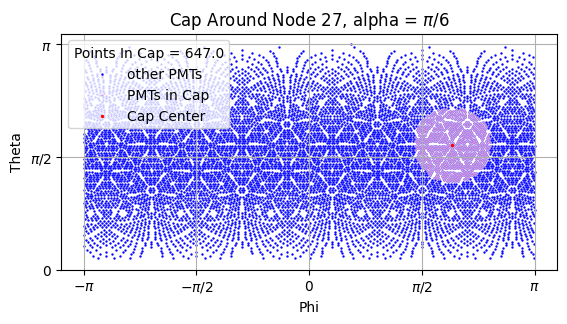

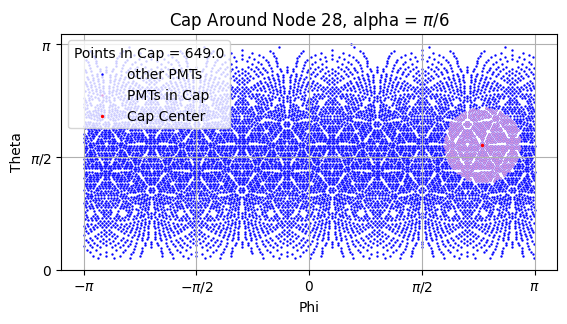

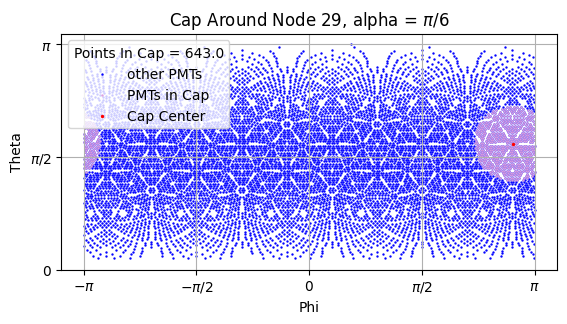

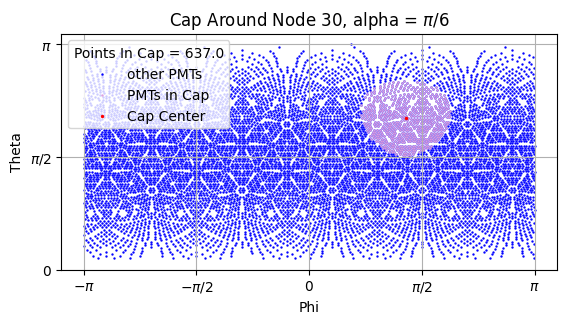

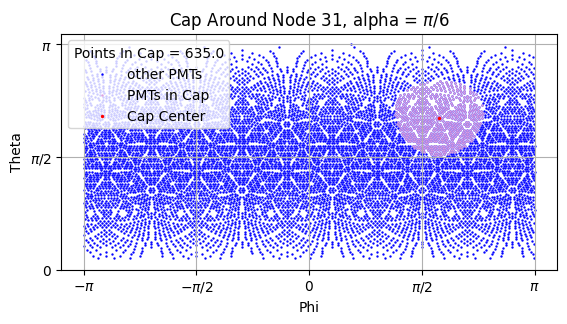

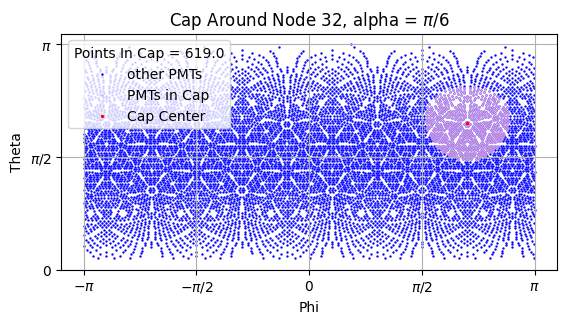

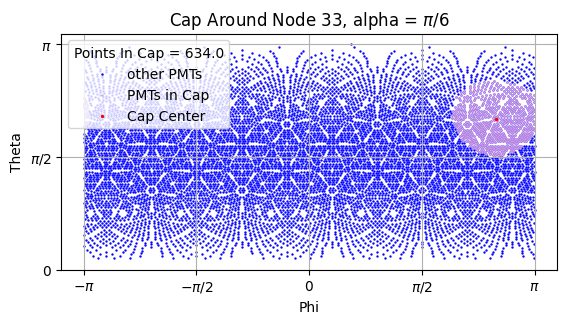

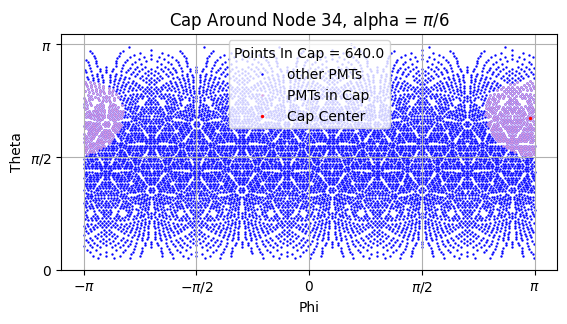

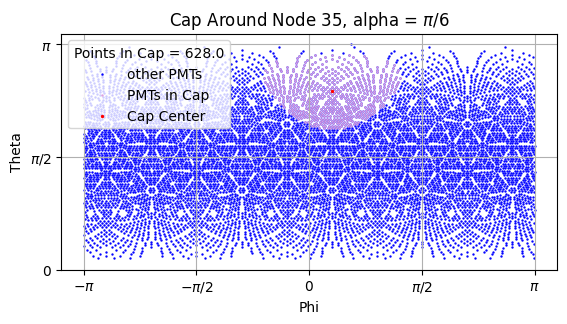

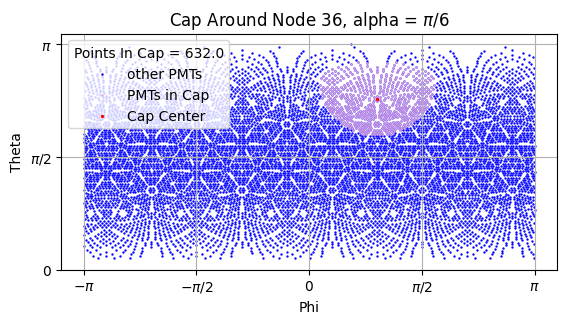

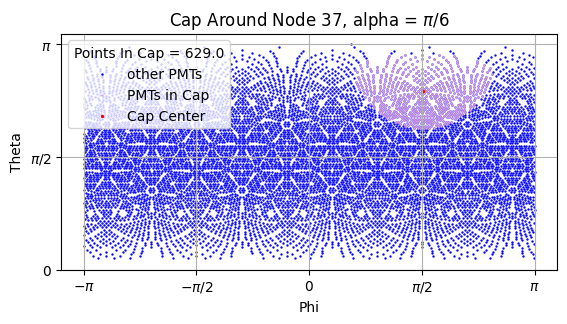

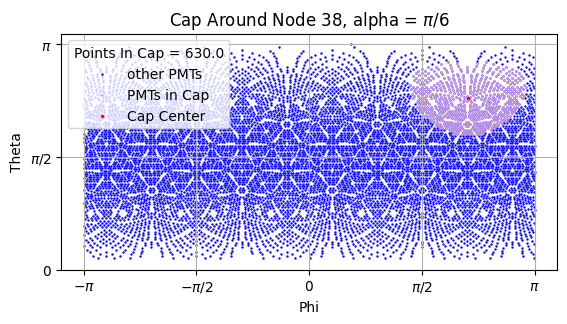

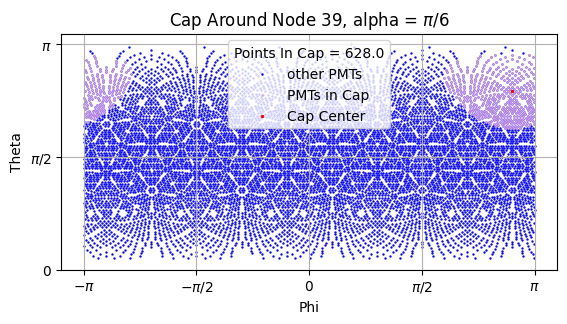

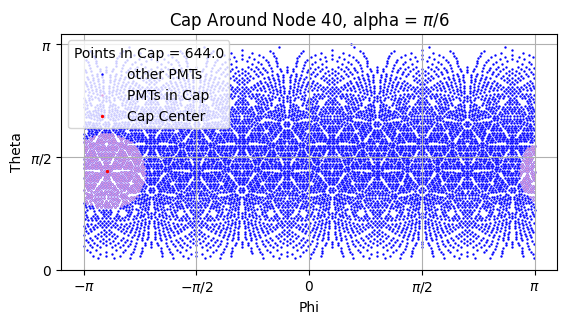

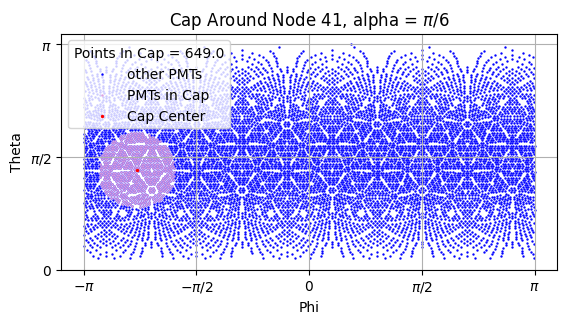

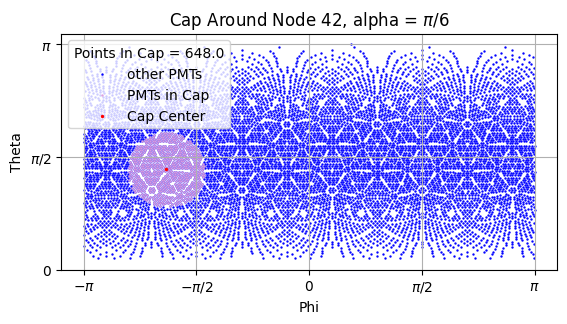

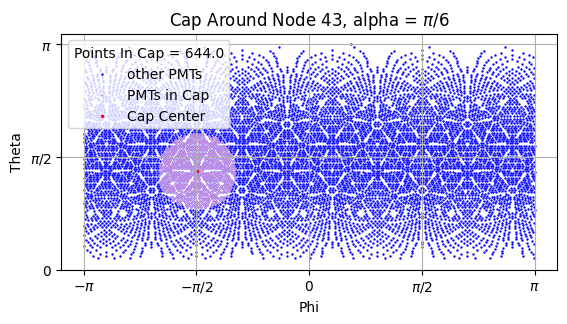

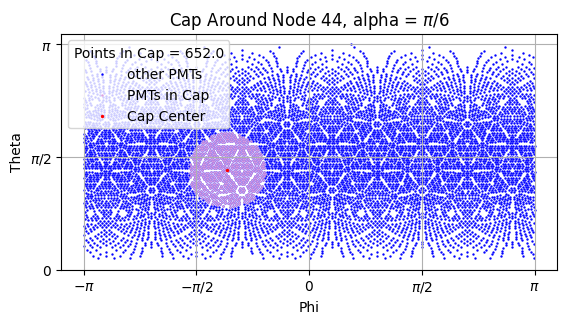

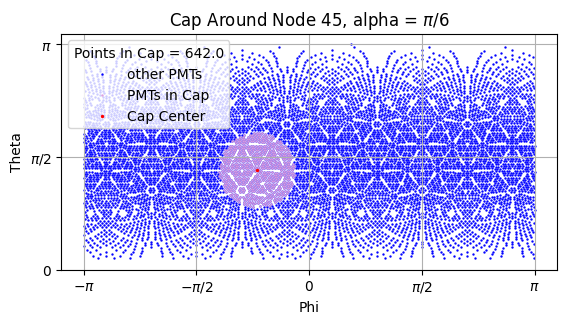

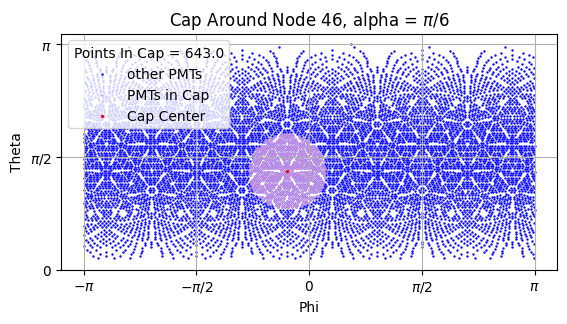

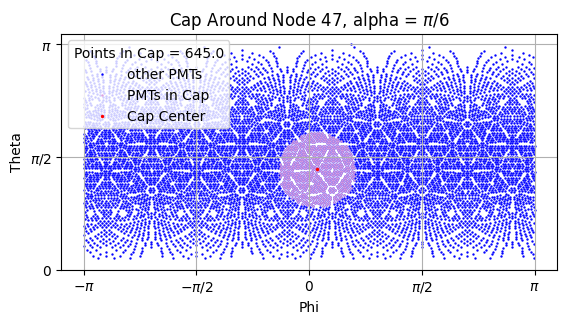

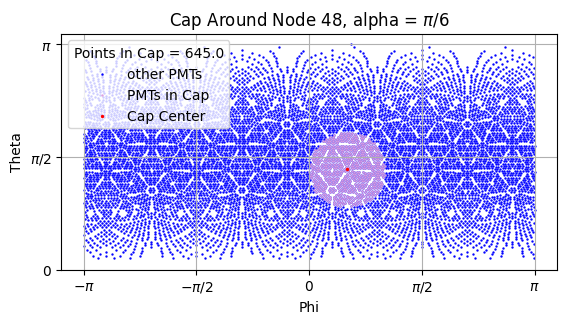

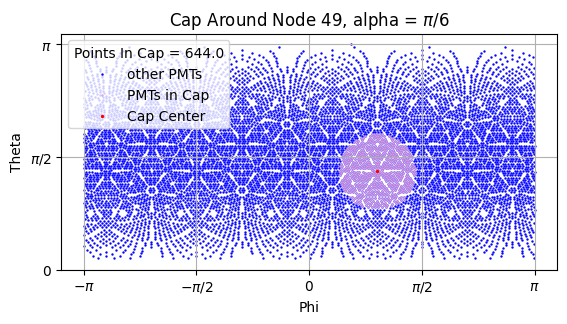

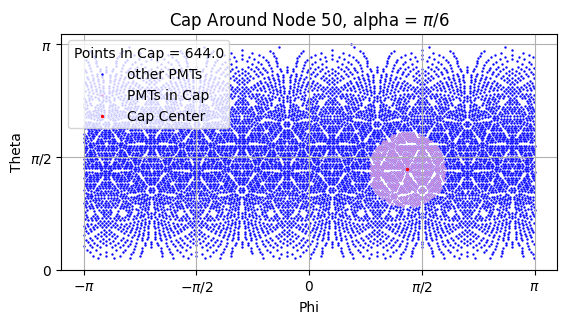

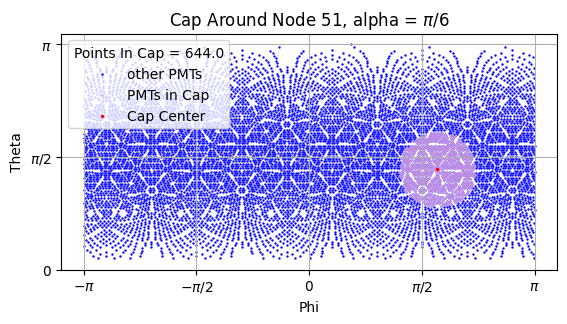

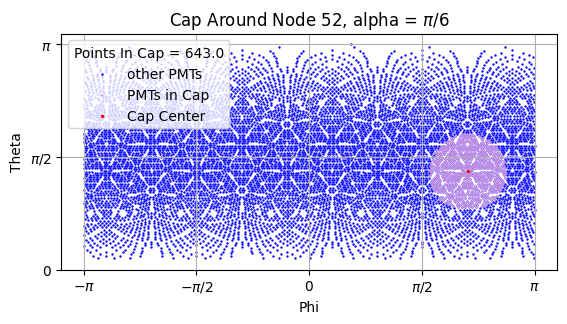

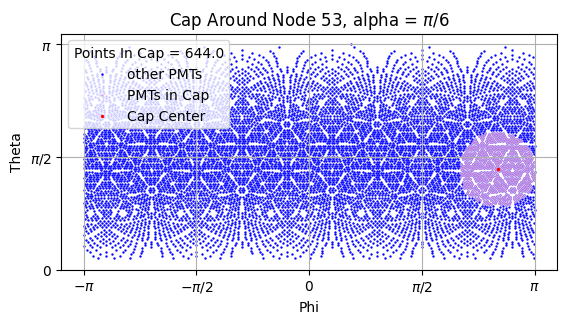

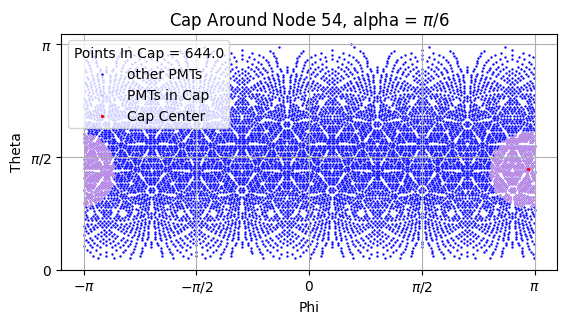

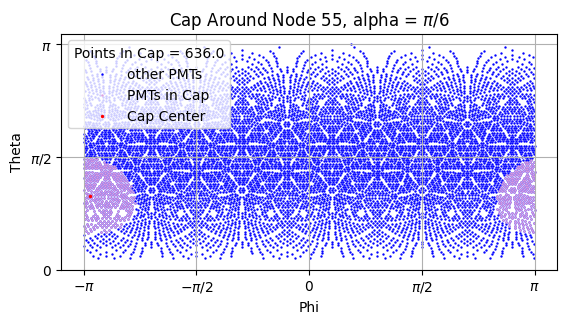

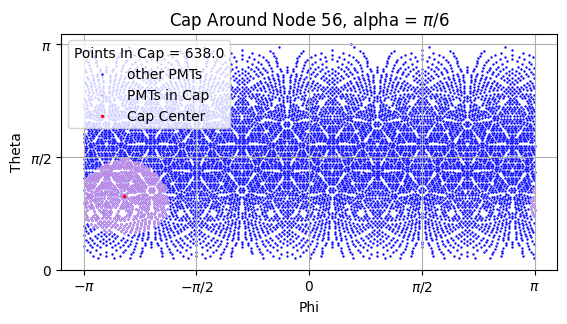

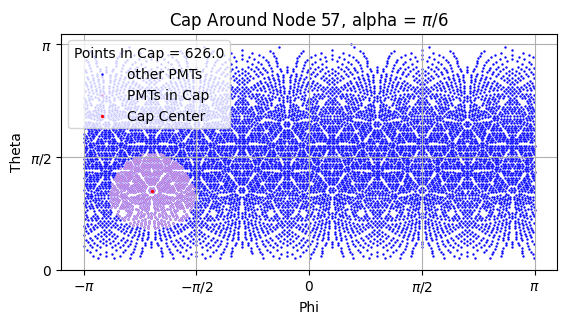

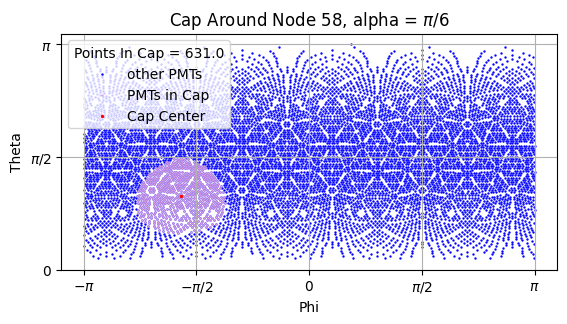

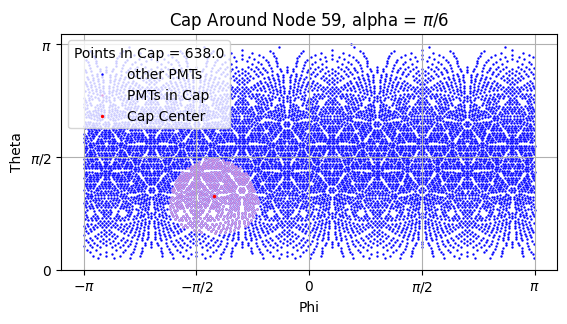

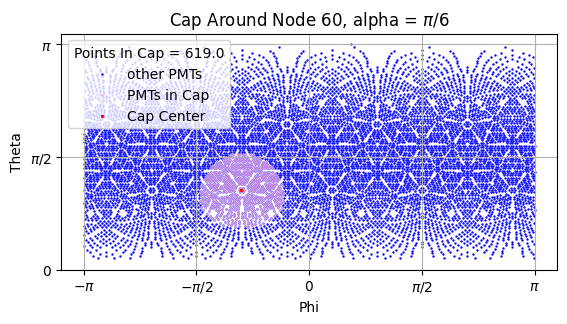

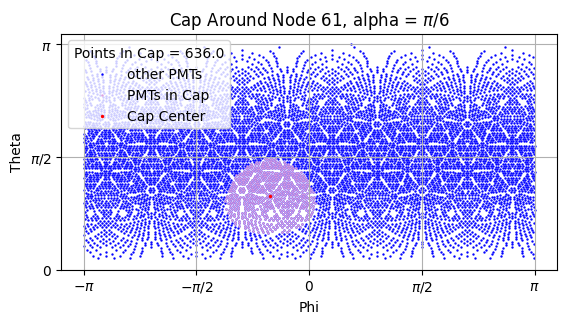

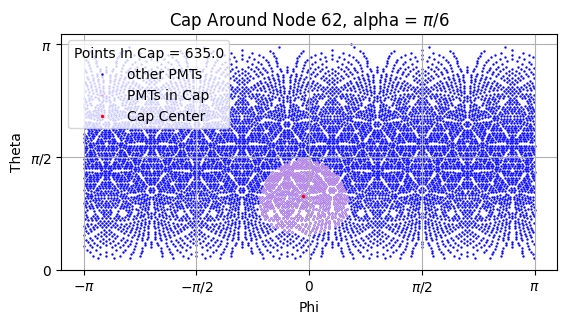

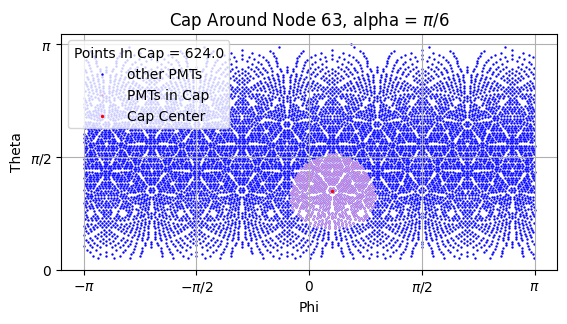

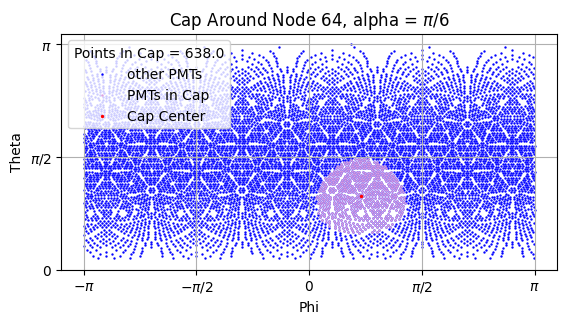

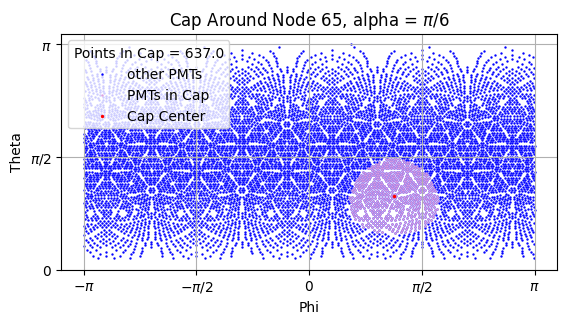

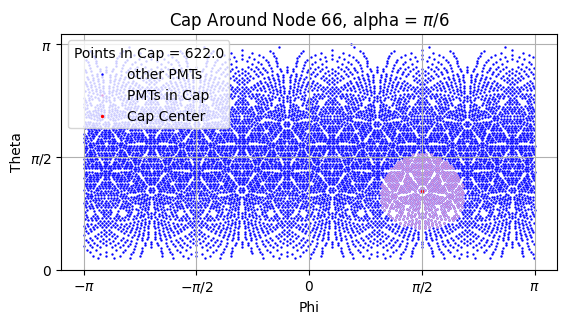

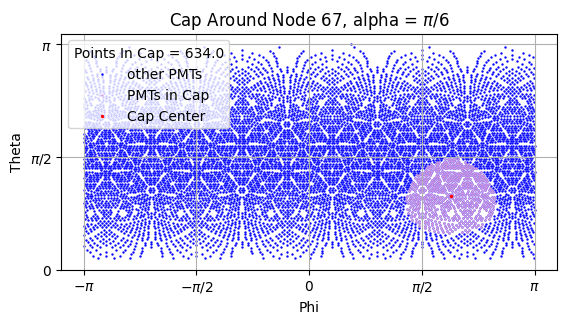

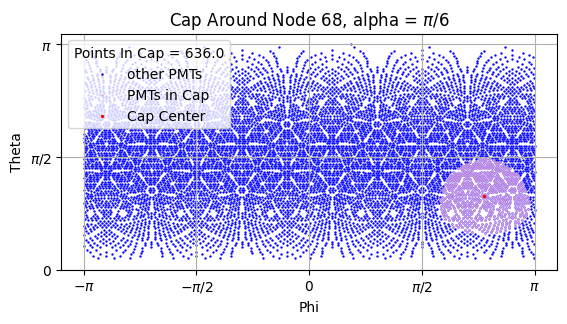

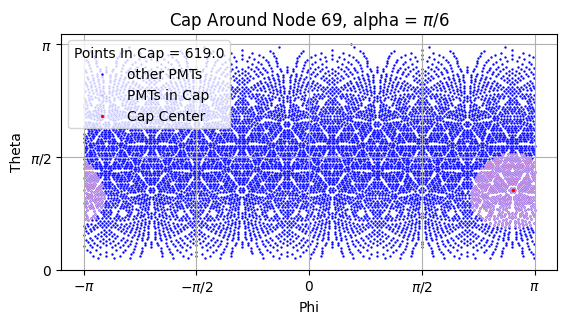

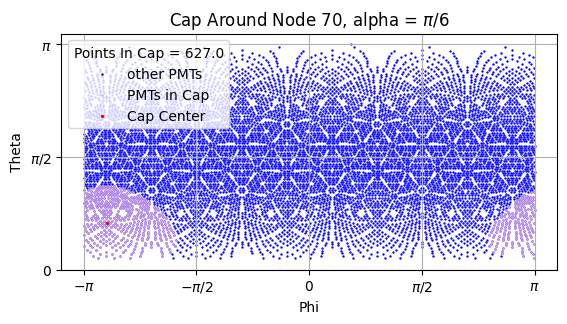

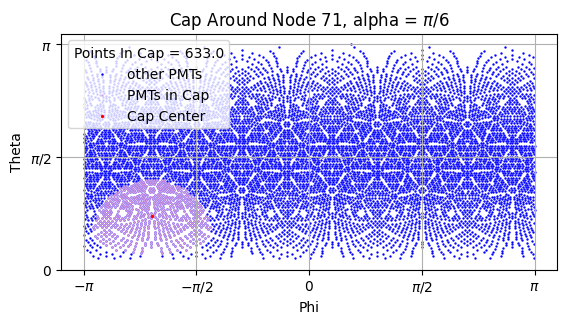

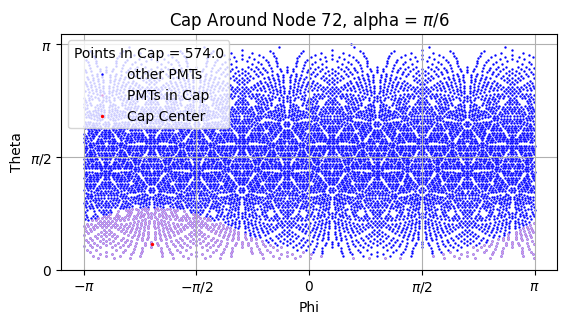

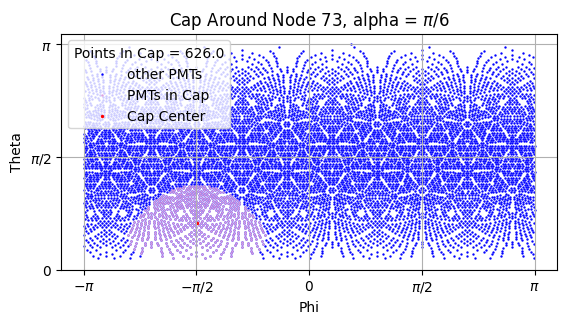

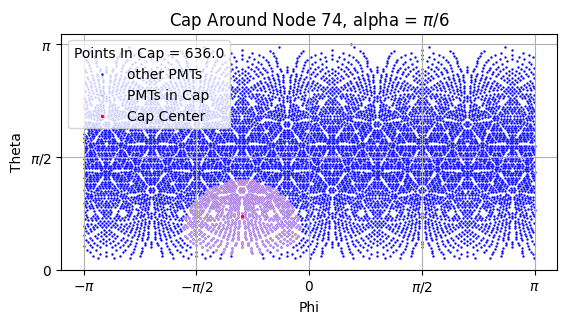

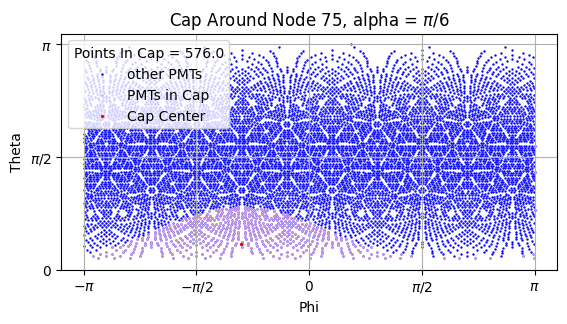

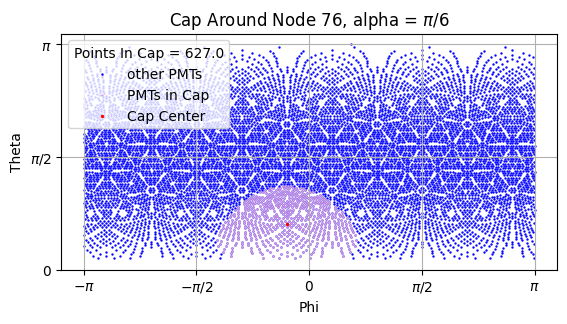

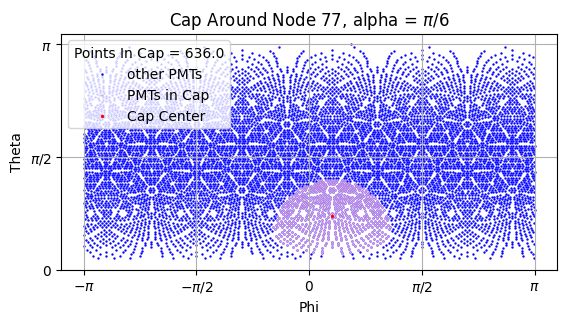

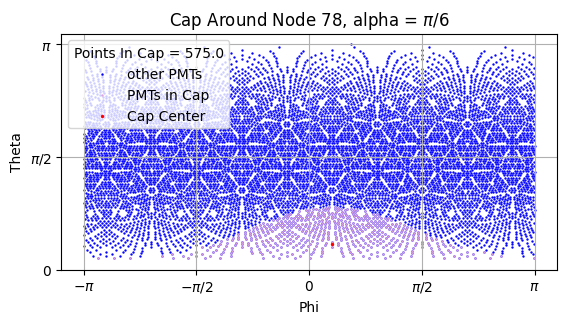

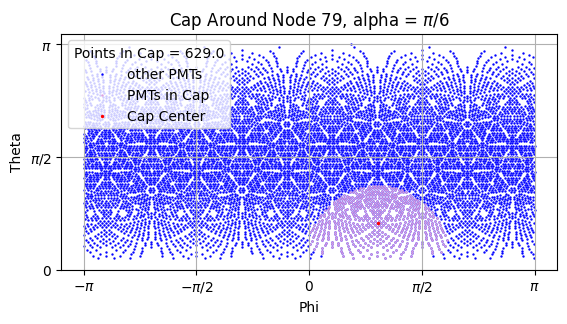

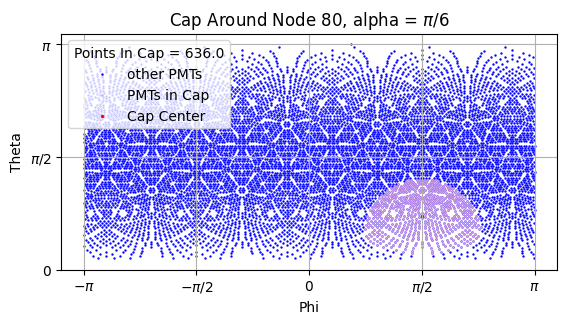

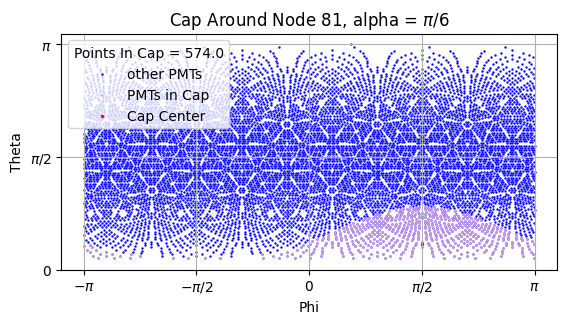

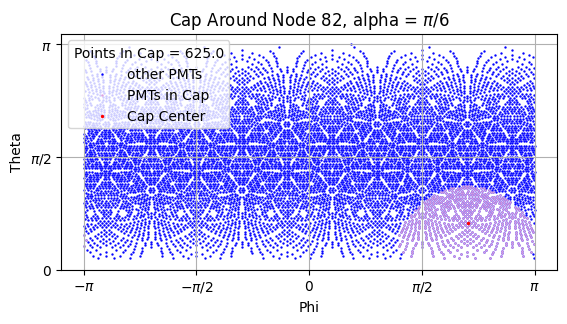

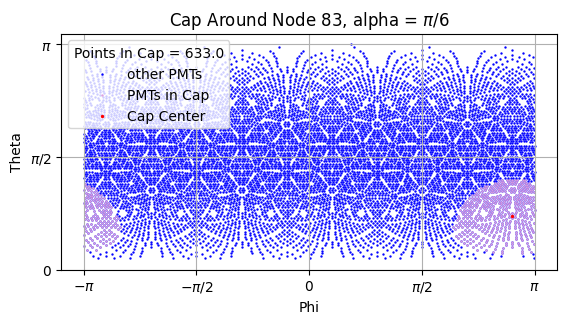

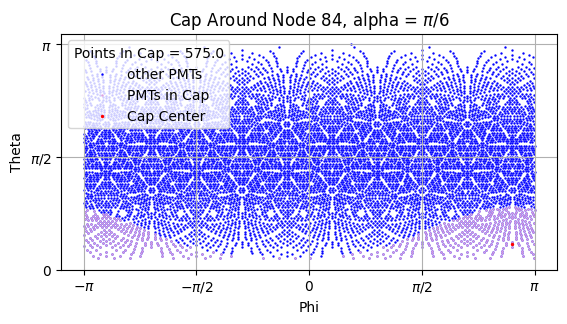

In [19]:
points_in_cap_count = np.zeros((len(points_set_2)))

for i in range(len(points_set_2)):
    cap_center = points_set_2[i]
    cap_center_polars = new_nodes[i]
    points_in_cap_set = []
    
    
    pi_over = 6
    
    for j in range(len(rescaled_data)):
        angle = angle_between_vectors(cap_center, rescaled_data[j])
        if angle < np.pi/pi_over:
            points_in_cap_set.append(rescaled_data[j])
            
    points_in_cap_set = np.array(points_in_cap_set)
    
    points_in_cap_polars = convert_points_to_spherical(points_in_cap_set)
    
    points_phi_cap = np.zeros(len(points_in_cap_polars))
    points_theta_cap = np.zeros(len(points_in_cap_polars))
    
    for j in range(len(points_in_cap_polars)):
        points_phi_cap[j] = points_in_cap_polars[j][1]
        points_theta_cap[j] = points_in_cap_polars[j][2]
        
    # Plot the grid points
    # Plot points_phi and points_theta
    plt.scatter(points_phi, points_theta, s=0.5, color='blue', label='other PMTs')
    # Plot points_phi_cap and points_theta_cap
    plt.scatter(points_phi_cap, points_theta_cap, s=0.5, color='plum', label='PMTs in Cap')
    # Plot cap_center_polars
    plt.scatter(cap_center_polars[1], cap_center_polars[2], s=2, color='red', label='Cap Center')
    
    # Count of points in the cap
    points_in_cap_count[i] = len(points_in_cap_set)

    # Add legend with count of points in the cap
    plt.legend(title='Points In Cap = {}'.format(points_in_cap_count[i]))
    
    # Set x-axis ticks
    plt.xticks(np.linspace(-np.pi, np.pi, 5), 
               ['$-\pi$', '$-\pi/2$', '$0$', '$\pi/2$', '$\pi$'])
    
    # Set y-axis ticks
    plt.yticks(np.linspace(0, np.pi, 3), 
               ['$0$', '$\pi/2$', '$\pi$'])
    
    plt.xlabel('Phi')
    plt.ylabel('Theta')
    plt.title('Cap Around Node '+str(i)+', alpha = $\pi$/'+str(pi_over))
    # Set aspect ratio to 'equal'
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt.savefig('CapAroundNode'+str(i)+'_PiOver'+str(pi_over)+'.pdf', format='pdf')
    
    plt.grid(True)
    plt.show()

In [22]:
# calculate peaks

def peak_value(N, alpha):
    return N * (1 - np.cos(alpha))/2

N = 9389

peak = peak_value(N, np.pi/6)


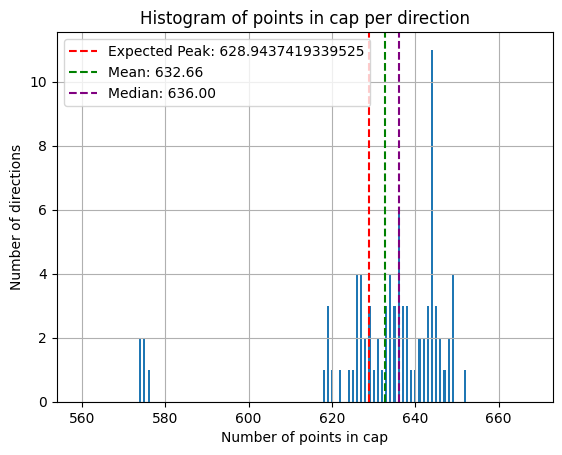

In [29]:
# Compute histogram
hist_values, bin_edges = np.histogram(points_in_cap_count, bins=np.arange(points_in_cap_count.max() + 2))

# Plot histogram
plt.bar(bin_edges[:-1], hist_values, width=0.5, align='center')

plt.xlabel('Number of points in cap')

# Find the first non-zero bin edge
non_zero_index = np.nonzero(hist_values)[0][0]

# Automatically adjust x-axis limits
xmin = bin_edges[non_zero_index] - 20
xmax = max(bin_edges) + 20
plt.xlim(xmin, xmax)

plt.ylabel('Number of directions')
plt.title('Histogram of points in cap per direction')
plt.grid(True)

plt.axvline(x=peak, color='red', linestyle='--', label='Expected Peak: {}'.format(peak))

# Compute mean and median
mean_value = np.mean(points_in_cap_count)
median_value = np.median(points_in_cap_count)

# Plot mean and median as vertical lines
plt.axvline(x=mean_value, color='green', linestyle='--', label='Mean: {:.2f}'.format(mean_value))
plt.axvline(x=median_value, color='purple', linestyle='--', label='Median: {:.2f}'.format(median_value))

# Add legend
plt.legend()

plt.savefig("MinimalNodesGrid_AllPMTs_PiOver6.pdf", format='pdf')
plt.show()